In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
print(tf.__version__)

tf.test.gpu_device_name()

2.15.0


'/device:GPU:0'

In [ ]:
!python --version

Python 3.10.12


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
dog_dataset = '70-Dog-Breeds-Image-Data-Set'

# directory bisa disesuaikan
cur_dir = '/content/gdrive/MyDrive/Capstone-Project/Dataset'

# # uncomment jika directory belum dibuat
# dog_mkdir = os.mkdir(cur_dir + '/Dog-Breeds')

# membuat directory untuk dataset dog
dog_dir = os.path.join(cur_dir, 'Dog-Breeds')

In [ ]:
def unzip_file(files, destination_dir):
  os.chdir(cur_dir)
  zip_file = f'{files}.zip'
  if not os.path.exists(zip_file):
    print(f'Error: {zip_file} not found!')
  else:
    ! unzip -q $zip_file -d $destination_dir
  return files,destination_dir

In [ ]:
# unzip_file(dog_dataset, dog_dir)

In [ ]:
os.listdir(dog_dir)

['dogs.csv', 'test', 'train', 'valid']

In [ ]:
def list_class(path, dir):
  class_name = sorted(os.listdir(os.path.join(path, dir)))
  return class_name

def list_content(path, class_name, slice):
  return os.listdir(os.path.join(path, slice, class_name))

In [ ]:
class_dog = list_class(dog_dir,'train')

print(f"Total dog class: {len(class_dog)}")

Total dog class: 70


In [ ]:
dog_class_list = np.asarray(list(class_dog))
dog_class_list

array(['Afghan', 'African Wild Dog', 'Airedale', 'American Hairless',
       'American Spaniel', 'Basenji', 'Basset', 'Beagle',
       'Bearded Collie', 'Bermaise', 'Bichon Frise', 'Blenheim',
       'Bloodhound', 'Bluetick', 'Border Collie', 'Borzoi',
       'Boston Terrier', 'Boxer', 'Bull Mastiff', 'Bull Terrier',
       'Bulldog', 'Cairn', 'Chihuahua', 'Chinese Crested', 'Chow',
       'Clumber', 'Cockapoo', 'Cocker', 'Collie', 'Corgi', 'Coyote',
       'Dalmation', 'Dhole', 'Dingo', 'Doberman', 'Elk Hound',
       'French Bulldog', 'German Sheperd', 'Golden Retriever',
       'Great Dane', 'Great Perenees', 'Greyhound', 'Groenendael',
       'Irish Spaniel', 'Irish Wolfhound', 'Japanese Spaniel', 'Komondor',
       'Labradoodle', 'Labrador', 'Lhasa', 'Malinois', 'Maltese',
       'Mex Hairless', 'Newfoundland', 'Pekinese', 'Pit Bull',
       'Pomeranian', 'Poodle', 'Pug', 'Rhodesian', 'Rottweiler',
       'Saint Bernard', 'Schnauzer', 'Scotch Terrier', 'Shar_Pei',
       'Shiba In

## Building Dog Classifier Model

In [ ]:
TRAIN_DOG_DIR = os.path.join(dog_dir,'train')
TEST_DOG_DIR = os.path.join(dog_dir,'test')
VAL_DOG_DIR = os.path.join(dog_dir,'valid')

print(TRAIN_DOG_DIR)
print(TEST_DOG_DIR)
print(VAL_DOG_DIR)

/content/gdrive/MyDrive/Capstone-Project/Dataset/Dog-Breeds/train
/content/gdrive/MyDrive/Capstone-Project/Dataset/Dog-Breeds/test
/content/gdrive/MyDrive/Capstone-Project/Dataset/Dog-Breeds/valid


In [ ]:
files = []
label = []
for dirname, _, filenames in os.walk(TRAIN_DOG_DIR):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))
        if dirname.split(os.sep)[8] not in label:
            label.append(dirname.split(os.sep)[8])

In [ ]:
df = pd.DataFrame(list(zip(files, label)), columns = ['Filepath', 'Labels'] )
df = (df.sample(frac = 1, random_state=42).reset_index()).drop(columns = 'index')
df.head()

,Filepath,Labels
0,/content/gdrive/MyDrive/Capstone-Project/Datas...,Chihuahua
1,/content/gdrive/MyDrive/Capstone-Project/Datas...,Afghan
2,/content/gdrive/MyDrive/Capstone-Project/Datas...,Lhasa
3,/content/gdrive/MyDrive/Capstone-Project/Datas...,American Spaniel
4,/content/gdrive/MyDrive/Capstone-Project/Datas...,Pekinese


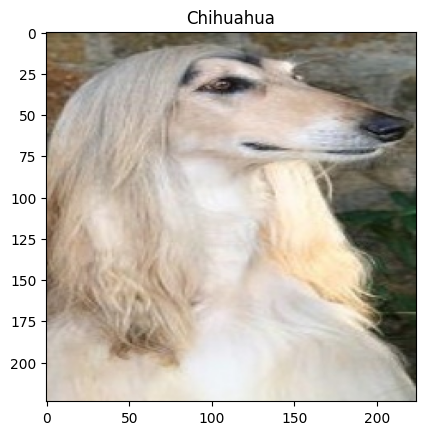

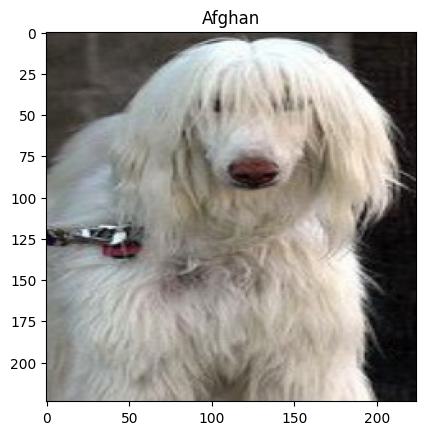

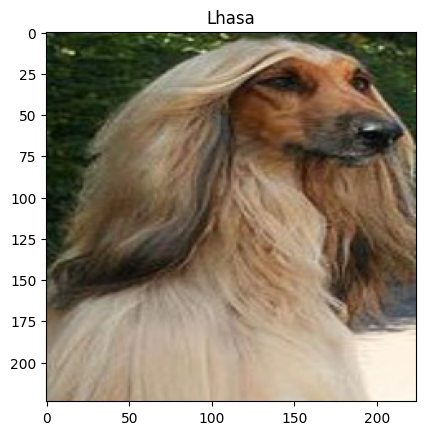

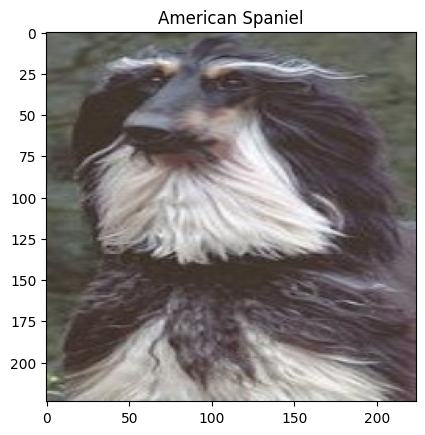

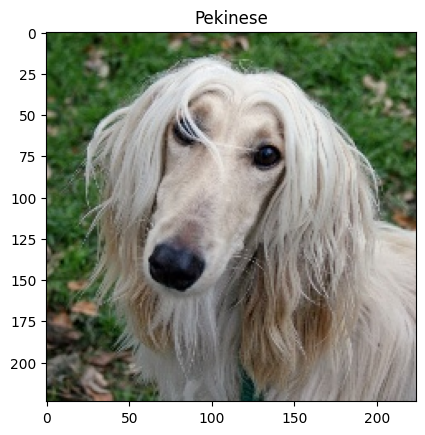

In [ ]:
for x in range(5):
    plt.title(df.Labels[x])
    plt.imshow(plt.imread(df.Filepath[x]))
    plt.show()

In [ ]:
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_data = data_gen.flow_from_directory(
    directory=TRAIN_DOG_DIR,
    batch_size=64,
    shuffle=True,
    subset='training',
    target_size=(224,224),
    class_mode='categorical'
)

test_data = data_gen.flow_from_directory(
    directory=TEST_DOG_DIR,
    batch_size=64,
    shuffle=True,
    target_size=(224,224),
    class_mode='categorical'
)

val_data = data_gen.flow_from_directory(
    directory=VAL_DOG_DIR,
    batch_size=64,
    shuffle=True,
    subset='validation',
    target_size=(224,224),
    class_mode='categorical'
)

Found 6390 images belonging to 70 classes.
Found 700 images belonging to 70 classes.
Found 140 images belonging to 70 classes.


In [ ]:
base_model = InceptionV3(input_shape=(224,224,3), weights='imagenet', include_top=False)

base_model.trainable = False

inputs = Input(shape=(224, 224, 3))

x = base_model(inputs)
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(70, activation='softmax')(x)

dog_model = Model(inputs=inputs, outputs=predictions)

dog_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
dog_model._name = 'Dog_Model'
dog_model.summary(show_trainable=True)

Model: "Dog_Model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 inception_v3 (Functional)   (None, 5, 5, 2048)        2180278   N          
                                                       4                    
                                                                            
 dropout (Dropout)           (None, 5, 5, 2048)        0         Y          
                                                                            
 global_average_pooling2d (  (None, 2048)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dense (Dense)               (None, 70)                14

In [ ]:
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=2)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4)

In [ ]:
history = dog_model.fit(
    train_data, validation_data=val_data, epochs=50,
    callbacks= [reduce_lr,early_stopping]
)

Epoch 1/50
100/100 [==============================] - 2288s 23s/step - loss: 0.8511 - accuracy: 0.8044 - val_loss: 0.1806 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - 35s 349ms/step - loss: 0.2388 - accuracy: 0.9238 - val_loss: 0.1783 - val_accuracy: 0.9571 - lr: 0.0010
Epoch 3/50
100/100 [==============================] - 34s 338ms/step - loss: 0.1809 - accuracy: 0.9429 - val_loss: 0.1646 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 4/50
100/100 [==============================] - 35s 347ms/step - loss: 0.1386 - accuracy: 0.9548 - val_loss: 0.1367 - val_accuracy: 0.9643 - lr: 0.0010
Epoch 5/50
100/100 [==============================] - 35s 349ms/step - loss: 0.1104 - accuracy: 0.9648 - val_loss: 0.1337 - val_accuracy: 0.9643 - lr: 0.0010
Epoch 6/50
100/100 [==============================] - 35s 351ms/step - loss: 0.0911 - accuracy: 0.9723 - val_loss: 0.1828 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 7/50
100/100 [==============================] 

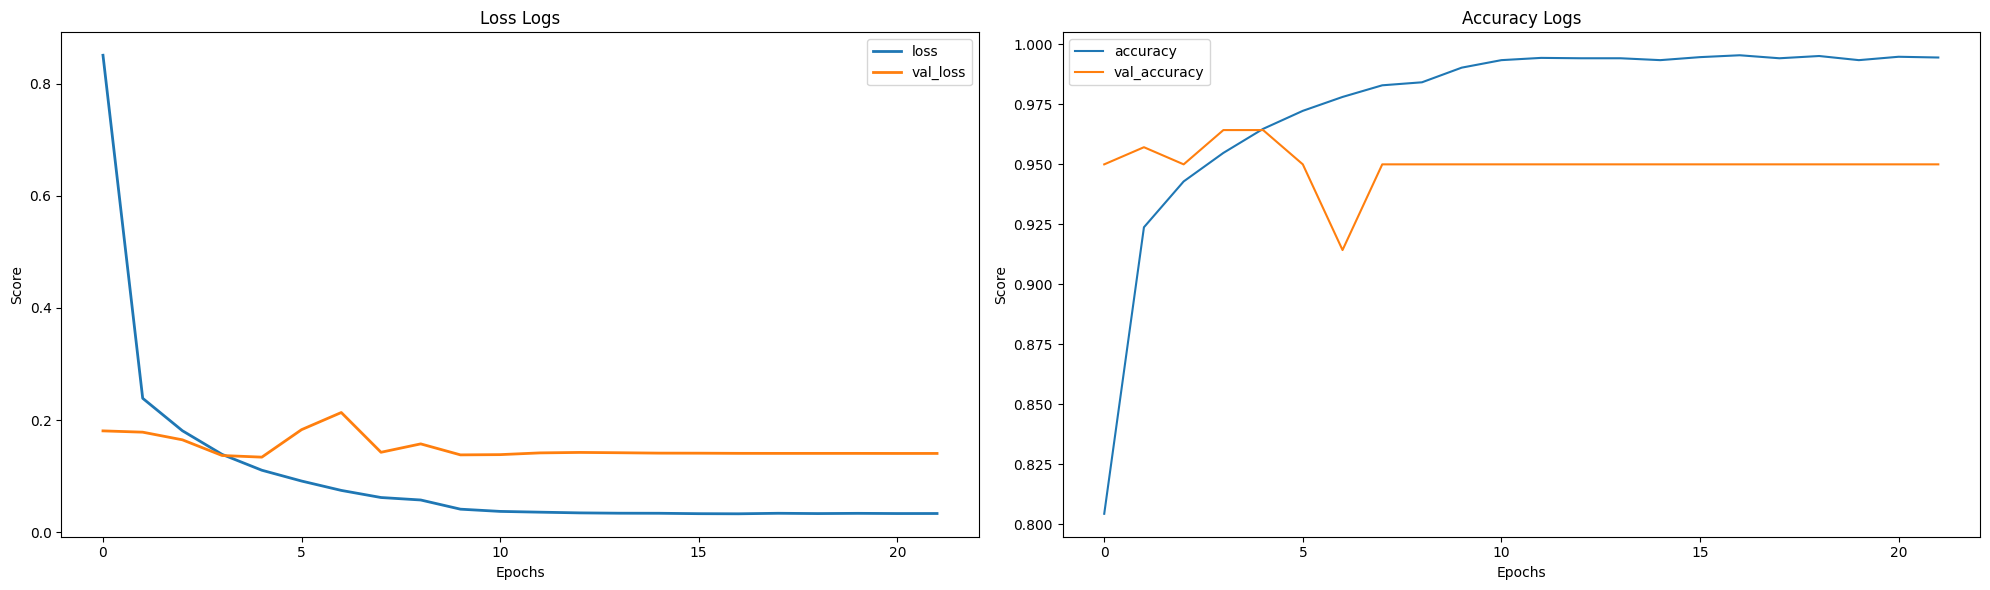

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plotting loss logs
axes[0].plot(history.history['loss'], label='loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='val_loss', linewidth=2)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Score')
axes[0].set_title('Loss Logs')
axes[0].legend()

# Plotting accuracy logs
axes[1].plot(history.history['accuracy'], label='accuracy')
axes[1].plot(history.history['val_accuracy'], label='val_accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Score')
axes[1].set_title('Accuracy Logs')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
test_accuracy = dog_model.evaluate(test_data, verbose=2, return_dict=False)
print("\033[94m" + "\033[1m" + "Test Accuracy: {:.2%}".format(test_accuracy[1]))

11/11 - 258s - loss: 0.1034 - accuracy: 0.9671 - 258s/epoch - 23s/step
Test Accuracy: 96.71%


In [ ]:
val_accuracy = dog_model.evaluate(val_data, verbose=2, return_dict=False)
print("\033[94m" + "\033[1m" + "Validation Accuracy: {:.2%}".format(val_accuracy[1]))

3/3 - 1s - loss: 0.1405 - accuracy: 0.9500 - 937ms/epoch - 312ms/step
Validation Accuracy: 95.00%


In [ ]:
dog_model.save('dog_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 95.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 101.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 96.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 108.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 33.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
   

In [ ]:
!tensorflowjs_converter --input_format=keras '/content/dog_model.h5' "/content/gdrive/MyDrive/Capstone-Project/json"

2024-06-15 05:43:01.951133: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 05:43:04.410373: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
